## Imports

In [1]:
import os
import time

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from torchvision import datasets
from torchvision import transforms

import matplotlib.pyplot as plt
from PIL import Image

from tqdm import tqdm

if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

## Model Settings

In [2]:
RANDOM_SEED = 1
LEARNING_RATE = 0.00001
BATCH_SIZE = 32
NUM_EPOCHS = 20

RESOLUTION = 100
NUM_FEATURES = RESOLUTION*RESOLUTION
NUM_CLASSES = 66

DEVICE = "cuda:0"
GRAYSCALE = False

In [4]:
transform = transforms.Compose([
    transforms.Resize(RESOLUTION),
    transforms.CenterCrop(RESOLUTION),
    transforms.ToTensor()
])

path = 'CV_data/dataset_augmented'
dataset = datasets.ImageFolder(root=path, transform=transform)


# Get class to index mapping
class_to_idx = dataset.class_to_idx

# Define index to class mapping
idx_to_class = {v: k for k, v in class_to_idx.items()}

train_size = int(0.6 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size

# Split the dataset into training set and test set
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
    dataset, [train_size, val_size, test_size])


train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=BATCH_SIZE, 
                          shuffle=True)

val_loader = DataLoader(dataset=val_dataset, 
                        batch_size=BATCH_SIZE, 
                        shuffle=False)

test_loader = DataLoader(dataset=test_dataset, 
                         batch_size=BATCH_SIZE, 
                         shuffle=True)

# Checking the dataset
for images, labels in train_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    print('Labels:', labels)
    break


Image batch dimensions: torch.Size([32, 3, 100, 100])
Image label dimensions: torch.Size([32])
Labels: tensor([61, 50, 13,  6, 56, 29, 10, 38, 47, 40, 28, 32, 23, 44, 42, 20, 47, 44,
        10, 17, 60, 30,  7,  3, 44, 18, 18,  0, 23, 45, 63, 31])


In [5]:
from collections import Counter


train_classes = [dataset.targets[i] for i in train_dataset.indices]
class_weights = 1 / torch.tensor(list(dict(sorted(dict(Counter(train_classes)).items())).values()))
class_weights

tensor([0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005,
        0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005,
        0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005,
        0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005,
        0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005,
        0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005,
        0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005,
        0.0005, 0.0005, 0.0005])

In [6]:
device = torch.device(DEVICE)
torch.manual_seed(0)

for epoch in range(2):

    for batch_idx, (x, y) in enumerate(train_loader):
        
        print('Epoch:', epoch+1, end='')
        print(' | Batch index:', batch_idx, end='')
        print(' | Batch size:', y.size()[0])
        
        x = x.to(device)
        y = y.to(device)
        break

Epoch: 1 | Batch index: 0 | Batch size: 32
Epoch: 2 | Batch index: 0 | Batch size: 32


# Model

In [7]:
def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out




class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes, grayscale):
        self.inplanes = 64
        if grayscale:
            in_dim = 1
        else:
            in_dim = 3
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(in_dim, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d(4, stride=1)
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, (2. / n)**.5)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        
        x = x.view(x.size(0), -1)
        logits = self.fc(x)
        probas = F.softmax(logits, dim=1)
        return logits, probas



def resnet18(num_classes):
    """Constructs a ResNet-18 model."""
    model = ResNet(block=BasicBlock, 
                   layers=[2, 2, 2, 2],
                   num_classes=NUM_CLASSES,
                   grayscale=GRAYSCALE)
    return model


In [8]:
torch.manual_seed(RANDOM_SEED)

model = resnet18(NUM_CLASSES)
model.to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)  

In [9]:
def compute_accuracy(model, data_loader, device, mode="train"):
    correct_pred, num_examples = 0, 0
    for batch_idx, (features, targets) in tqdm(enumerate(data_loader)):
            
        features = features.to(DEVICE)
        targets = targets.to(DEVICE)

        logits, probas = model(features)
        _, predicted_labels = torch.max(probas, 1)
        num_examples += targets.size(0)
        correct_pred += (predicted_labels == targets).sum()
        
        if not batch_idx % 50:
            accuracy = correct_pred.float() / num_examples * 100
            with open(f'CV_data/models/{model_name}-{LEARNING_RATE}-{mode}-accuracy.csv', 'a') as fp:
                fp.write(f"{epoch+1}, {batch_idx}, {accuracy}\n")
            correct_pred, num_examples = 0, 0



In [10]:
def compute_loss(model, data_loader, class_weights, device, mode="val"):
    losses = []
    dataset_len = len(data_loader)
    for batch_idx, (features, targets) in tqdm(enumerate(data_loader)):
        
        features = features.to(DEVICE)
        targets = targets.to(DEVICE)
        class_weights = class_weights.to(DEVICE)
            
        logits, _ = model(features)
        loss = F.cross_entropy(logits, targets)
        losses.append(loss)
        
        if not batch_idx % 50:
            mean_loss = sum(losses) / len(losses)
            with open(f'CV_data/models/{model_name}-{LEARNING_RATE}-{mode}-loss.csv', 'a') as fp:
                fp.write(f"{epoch+1}, {batch_idx}, {mean_loss}\n")
            losses.clear()

In [11]:
model_name = "08-model"

## Training

In [12]:

start_time = time.time()

for epoch in range(NUM_EPOCHS):
        model.train()
        losses = []
        for batch_idx, (features, targets) in enumerate(train_loader):

            features = features.to(DEVICE)
            targets = targets.to(DEVICE)
            class_weights = class_weights.to(DEVICE)

            ### FORWARD AND BACK PROP
            logits, probas = model(features)
            loss = F.cross_entropy(logits, targets)
            losses.append(loss)

            optimizer.zero_grad()

            loss.backward()

            ### UPDATE MODEL PARAMETERS
            optimizer.step()

            ### LOGGING
            if not batch_idx % 50:
                print ('Epoch: %03d/%03d | Batch %04d/%04d | Cost: %.4f' 
                       %(epoch+1, NUM_EPOCHS, batch_idx,
                         len(train_loader), loss))

                mean_loss = sum(losses) / len(losses)
                with open(f'CV_data/models/{model_name}-{LEARNING_RATE}-train-loss.csv', 'a') as fp:
                    fp.write(f"{epoch+1}, {batch_idx}, {mean_loss}\n")
                losses.clear()


        model.eval()
        with torch.set_grad_enabled(False): # save memory during inference
            compute_accuracy(model, train_loader, device=DEVICE, mode="train")
            compute_loss(model, val_loader, class_weights, device=DEVICE, mode="val")
            compute_accuracy(model, val_loader, device=DEVICE, mode="val")

        file_path = f'CV_data/models/{model_name}-{LEARNING_RATE}-epoch{epoch+1}.pth'
        torch.save(model.state_dict(), file_path)

        print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))
    
    
    
print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

Epoch: 001/020 | Batch 0000/4332 | Cost: 4.2007
Epoch: 001/020 | Batch 0050/4332 | Cost: 4.2621
Epoch: 001/020 | Batch 0100/4332 | Cost: 4.1616
Epoch: 001/020 | Batch 0150/4332 | Cost: 4.0922
Epoch: 001/020 | Batch 0200/4332 | Cost: 3.8548
Epoch: 001/020 | Batch 0250/4332 | Cost: 3.7102
Epoch: 001/020 | Batch 0300/4332 | Cost: 3.5461
Epoch: 001/020 | Batch 0350/4332 | Cost: 3.5431
Epoch: 001/020 | Batch 0400/4332 | Cost: 3.3062
Epoch: 001/020 | Batch 0450/4332 | Cost: 3.2233
Epoch: 001/020 | Batch 0500/4332 | Cost: 3.2853
Epoch: 001/020 | Batch 0550/4332 | Cost: 3.1857
Epoch: 001/020 | Batch 0600/4332 | Cost: 3.1941
Epoch: 001/020 | Batch 0650/4332 | Cost: 2.8154
Epoch: 001/020 | Batch 0700/4332 | Cost: 2.6934
Epoch: 001/020 | Batch 0750/4332 | Cost: 2.6322
Epoch: 001/020 | Batch 0800/4332 | Cost: 2.5778
Epoch: 001/020 | Batch 0850/4332 | Cost: 2.5989
Epoch: 001/020 | Batch 0900/4332 | Cost: 2.4142
Epoch: 001/020 | Batch 0950/4332 | Cost: 2.4357
Epoch: 001/020 | Batch 1000/4332 | Cost:

4332it [05:38, 12.80it/s]
1444it [01:52, 12.86it/s]
1444it [01:50, 13.12it/s]


Time elapsed: 15.97 min
Epoch: 002/020 | Batch 0000/4332 | Cost: 0.7768
Epoch: 002/020 | Batch 0050/4332 | Cost: 0.5227
Epoch: 002/020 | Batch 0100/4332 | Cost: 0.8426
Epoch: 002/020 | Batch 0150/4332 | Cost: 0.5622
Epoch: 002/020 | Batch 0200/4332 | Cost: 1.2178
Epoch: 002/020 | Batch 0250/4332 | Cost: 1.2686
Epoch: 002/020 | Batch 0300/4332 | Cost: 0.7542
Epoch: 002/020 | Batch 0350/4332 | Cost: 0.7482
Epoch: 002/020 | Batch 0400/4332 | Cost: 0.7165
Epoch: 002/020 | Batch 0450/4332 | Cost: 0.6611
Epoch: 002/020 | Batch 0500/4332 | Cost: 1.3120
Epoch: 002/020 | Batch 0550/4332 | Cost: 0.6889
Epoch: 002/020 | Batch 0600/4332 | Cost: 0.9702
Epoch: 002/020 | Batch 0650/4332 | Cost: 0.7865
Epoch: 002/020 | Batch 0700/4332 | Cost: 0.9547
Epoch: 002/020 | Batch 0750/4332 | Cost: 0.6697
Epoch: 002/020 | Batch 0800/4332 | Cost: 0.9643
Epoch: 002/020 | Batch 0850/4332 | Cost: 0.7847
Epoch: 002/020 | Batch 0900/4332 | Cost: 0.8835
Epoch: 002/020 | Batch 0950/4332 | Cost: 0.7720
Epoch: 002/020 |

4332it [05:31, 13.05it/s]
1444it [01:47, 13.46it/s]
1444it [01:47, 13.40it/s]


Time elapsed: 31.58 min
Epoch: 003/020 | Batch 0000/4332 | Cost: 0.6801
Epoch: 003/020 | Batch 0050/4332 | Cost: 0.3265
Epoch: 003/020 | Batch 0100/4332 | Cost: 0.3401
Epoch: 003/020 | Batch 0150/4332 | Cost: 0.5003
Epoch: 003/020 | Batch 0200/4332 | Cost: 0.6804
Epoch: 003/020 | Batch 0250/4332 | Cost: 0.6093
Epoch: 003/020 | Batch 0300/4332 | Cost: 0.6262
Epoch: 003/020 | Batch 0350/4332 | Cost: 0.4454
Epoch: 003/020 | Batch 0400/4332 | Cost: 0.6278
Epoch: 003/020 | Batch 0450/4332 | Cost: 0.5848
Epoch: 003/020 | Batch 0500/4332 | Cost: 0.9057
Epoch: 003/020 | Batch 0550/4332 | Cost: 0.4215
Epoch: 003/020 | Batch 0600/4332 | Cost: 0.5605
Epoch: 003/020 | Batch 0650/4332 | Cost: 0.6113
Epoch: 003/020 | Batch 0700/4332 | Cost: 0.5596
Epoch: 003/020 | Batch 0750/4332 | Cost: 0.4983
Epoch: 003/020 | Batch 0800/4332 | Cost: 0.3901
Epoch: 003/020 | Batch 0850/4332 | Cost: 0.4645
Epoch: 003/020 | Batch 0900/4332 | Cost: 0.4523
Epoch: 003/020 | Batch 0950/4332 | Cost: 0.7594
Epoch: 003/020 |

4332it [05:31, 13.06it/s]
1444it [01:51, 13.00it/s]
1444it [01:48, 13.33it/s]


Time elapsed: 47.19 min
Epoch: 004/020 | Batch 0000/4332 | Cost: 0.3179
Epoch: 004/020 | Batch 0050/4332 | Cost: 0.4860
Epoch: 004/020 | Batch 0100/4332 | Cost: 0.4086
Epoch: 004/020 | Batch 0150/4332 | Cost: 0.4610
Epoch: 004/020 | Batch 0200/4332 | Cost: 0.6501
Epoch: 004/020 | Batch 0250/4332 | Cost: 0.2943
Epoch: 004/020 | Batch 0300/4332 | Cost: 0.2012
Epoch: 004/020 | Batch 0350/4332 | Cost: 0.2158
Epoch: 004/020 | Batch 0400/4332 | Cost: 0.1702
Epoch: 004/020 | Batch 0450/4332 | Cost: 0.1722
Epoch: 004/020 | Batch 0500/4332 | Cost: 0.4406
Epoch: 004/020 | Batch 0550/4332 | Cost: 0.3071
Epoch: 004/020 | Batch 0600/4332 | Cost: 0.2787
Epoch: 004/020 | Batch 0650/4332 | Cost: 0.6938
Epoch: 004/020 | Batch 0700/4332 | Cost: 0.7962
Epoch: 004/020 | Batch 0750/4332 | Cost: 0.3306
Epoch: 004/020 | Batch 0800/4332 | Cost: 0.2767
Epoch: 004/020 | Batch 0850/4332 | Cost: 0.2842
Epoch: 004/020 | Batch 0900/4332 | Cost: 0.4711
Epoch: 004/020 | Batch 0950/4332 | Cost: 0.1558
Epoch: 004/020 |

4332it [05:26, 13.27it/s]
1444it [01:47, 13.40it/s]
1444it [01:47, 13.46it/s]


Time elapsed: 62.61 min
Epoch: 005/020 | Batch 0000/4332 | Cost: 0.4098
Epoch: 005/020 | Batch 0050/4332 | Cost: 0.2673
Epoch: 005/020 | Batch 0100/4332 | Cost: 0.7899
Epoch: 005/020 | Batch 0150/4332 | Cost: 0.2958
Epoch: 005/020 | Batch 0200/4332 | Cost: 0.4604
Epoch: 005/020 | Batch 0250/4332 | Cost: 0.6379
Epoch: 005/020 | Batch 0300/4332 | Cost: 0.3189
Epoch: 005/020 | Batch 0350/4332 | Cost: 0.3411
Epoch: 005/020 | Batch 0400/4332 | Cost: 0.1365
Epoch: 005/020 | Batch 0450/4332 | Cost: 0.4261
Epoch: 005/020 | Batch 0500/4332 | Cost: 0.2879
Epoch: 005/020 | Batch 0550/4332 | Cost: 0.2228
Epoch: 005/020 | Batch 0600/4332 | Cost: 0.1718
Epoch: 005/020 | Batch 0650/4332 | Cost: 0.1247
Epoch: 005/020 | Batch 0700/4332 | Cost: 0.3105
Epoch: 005/020 | Batch 0750/4332 | Cost: 0.7289
Epoch: 005/020 | Batch 0800/4332 | Cost: 0.3623
Epoch: 005/020 | Batch 0850/4332 | Cost: 0.1859
Epoch: 005/020 | Batch 0900/4332 | Cost: 0.1461
Epoch: 005/020 | Batch 0950/4332 | Cost: 0.4446
Epoch: 005/020 |

4332it [05:30, 13.12it/s]
1444it [01:46, 13.51it/s]
1444it [01:47, 13.45it/s]


Time elapsed: 78.08 min
Epoch: 006/020 | Batch 0000/4332 | Cost: 0.4350
Epoch: 006/020 | Batch 0050/4332 | Cost: 0.2161
Epoch: 006/020 | Batch 0100/4332 | Cost: 0.1207
Epoch: 006/020 | Batch 0150/4332 | Cost: 0.2312
Epoch: 006/020 | Batch 0200/4332 | Cost: 0.0958
Epoch: 006/020 | Batch 0250/4332 | Cost: 0.4566
Epoch: 006/020 | Batch 0300/4332 | Cost: 0.0781
Epoch: 006/020 | Batch 0350/4332 | Cost: 0.4052
Epoch: 006/020 | Batch 0400/4332 | Cost: 0.2424
Epoch: 006/020 | Batch 0450/4332 | Cost: 0.2156
Epoch: 006/020 | Batch 0500/4332 | Cost: 0.1537
Epoch: 006/020 | Batch 0550/4332 | Cost: 0.5161
Epoch: 006/020 | Batch 0600/4332 | Cost: 0.1517
Epoch: 006/020 | Batch 0650/4332 | Cost: 0.2943
Epoch: 006/020 | Batch 0700/4332 | Cost: 0.1803
Epoch: 006/020 | Batch 0750/4332 | Cost: 0.1792
Epoch: 006/020 | Batch 0800/4332 | Cost: 0.1907
Epoch: 006/020 | Batch 0850/4332 | Cost: 0.1429
Epoch: 006/020 | Batch 0900/4332 | Cost: 0.2364
Epoch: 006/020 | Batch 0950/4332 | Cost: 0.2942
Epoch: 006/020 |

4332it [05:27, 13.25it/s]
1444it [01:48, 13.31it/s]
1444it [01:47, 13.37it/s]


Time elapsed: 93.62 min
Epoch: 007/020 | Batch 0000/4332 | Cost: 0.2229
Epoch: 007/020 | Batch 0050/4332 | Cost: 0.1801
Epoch: 007/020 | Batch 0100/4332 | Cost: 0.0764
Epoch: 007/020 | Batch 0150/4332 | Cost: 0.1184
Epoch: 007/020 | Batch 0200/4332 | Cost: 0.1354
Epoch: 007/020 | Batch 0250/4332 | Cost: 0.0406
Epoch: 007/020 | Batch 0300/4332 | Cost: 0.3572
Epoch: 007/020 | Batch 0350/4332 | Cost: 0.2579
Epoch: 007/020 | Batch 0400/4332 | Cost: 0.0527
Epoch: 007/020 | Batch 0450/4332 | Cost: 0.2482
Epoch: 007/020 | Batch 0500/4332 | Cost: 0.1011
Epoch: 007/020 | Batch 0550/4332 | Cost: 0.0838
Epoch: 007/020 | Batch 0600/4332 | Cost: 0.3169
Epoch: 007/020 | Batch 0650/4332 | Cost: 0.2458
Epoch: 007/020 | Batch 0700/4332 | Cost: 0.1235
Epoch: 007/020 | Batch 0750/4332 | Cost: 0.1591
Epoch: 007/020 | Batch 0800/4332 | Cost: 0.1092
Epoch: 007/020 | Batch 0850/4332 | Cost: 0.1070
Epoch: 007/020 | Batch 0900/4332 | Cost: 0.1046
Epoch: 007/020 | Batch 0950/4332 | Cost: 0.0872
Epoch: 007/020 |

4332it [05:28, 13.20it/s]
1444it [01:48, 13.31it/s]
1444it [01:52, 12.82it/s]


Time elapsed: 109.19 min
Epoch: 008/020 | Batch 0000/4332 | Cost: 0.1056
Epoch: 008/020 | Batch 0050/4332 | Cost: 0.0529
Epoch: 008/020 | Batch 0100/4332 | Cost: 0.0497
Epoch: 008/020 | Batch 0150/4332 | Cost: 0.1582
Epoch: 008/020 | Batch 0200/4332 | Cost: 0.1530
Epoch: 008/020 | Batch 0250/4332 | Cost: 0.0919
Epoch: 008/020 | Batch 0300/4332 | Cost: 0.1045
Epoch: 008/020 | Batch 0350/4332 | Cost: 0.0296
Epoch: 008/020 | Batch 0400/4332 | Cost: 0.2150
Epoch: 008/020 | Batch 0450/4332 | Cost: 0.1167
Epoch: 008/020 | Batch 0500/4332 | Cost: 0.0516
Epoch: 008/020 | Batch 0550/4332 | Cost: 0.0692
Epoch: 008/020 | Batch 0600/4332 | Cost: 0.1365
Epoch: 008/020 | Batch 0650/4332 | Cost: 0.0726
Epoch: 008/020 | Batch 0700/4332 | Cost: 0.0414
Epoch: 008/020 | Batch 0750/4332 | Cost: 0.1588
Epoch: 008/020 | Batch 0800/4332 | Cost: 0.0883
Epoch: 008/020 | Batch 0850/4332 | Cost: 0.2684
Epoch: 008/020 | Batch 0900/4332 | Cost: 0.0899
Epoch: 008/020 | Batch 0950/4332 | Cost: 0.0918
Epoch: 008/020 

4332it [05:32, 13.05it/s]
1444it [01:48, 13.36it/s]
1444it [02:17, 10.47it/s]
1444it [02:13, 10.83it/s]


Time elapsed: 317.71 min
Epoch: 020/020 | Batch 0000/4332 | Cost: 0.0023
Epoch: 020/020 | Batch 0050/4332 | Cost: 0.0105
Epoch: 020/020 | Batch 0100/4332 | Cost: 0.0009
Epoch: 020/020 | Batch 0150/4332 | Cost: 0.0042
Epoch: 020/020 | Batch 0200/4332 | Cost: 0.0167
Epoch: 020/020 | Batch 0250/4332 | Cost: 0.0022
Epoch: 020/020 | Batch 0300/4332 | Cost: 0.0039
Epoch: 020/020 | Batch 0350/4332 | Cost: 0.0029
Epoch: 020/020 | Batch 0400/4332 | Cost: 0.0084
Epoch: 020/020 | Batch 0450/4332 | Cost: 0.0044
Epoch: 020/020 | Batch 0500/4332 | Cost: 0.0794
Epoch: 020/020 | Batch 0550/4332 | Cost: 0.0018
Epoch: 020/020 | Batch 0600/4332 | Cost: 0.0235
Epoch: 020/020 | Batch 0650/4332 | Cost: 0.0943
Epoch: 020/020 | Batch 0700/4332 | Cost: 0.0023
Epoch: 020/020 | Batch 0750/4332 | Cost: 0.0049
Epoch: 020/020 | Batch 0800/4332 | Cost: 0.0014
Epoch: 020/020 | Batch 0850/4332 | Cost: 0.0210
Epoch: 020/020 | Batch 0900/4332 | Cost: 0.0007
Epoch: 020/020 | Batch 0950/4332 | Cost: 0.0078
Epoch: 020/020 

4332it [06:37, 10.90it/s]
1444it [02:14, 10.75it/s]
1444it [02:12, 10.86it/s]


Time elapsed: 336.11 min
Total Training Time: 336.11 min


## Evaluation

In [14]:
DEVICE = "cuda:0"
device = torch.device(DEVICE)

torch.manual_seed(RANDOM_SEED)

model_weights = torch.load(f"CV_data/models/{model_name}-{LEARNING_RATE}-epoch20.pth", map_location=torch.device('cpu'))

model = resnet18(NUM_CLASSES) 

# Loading the weights to the model
model.load_state_dict(model_weights)

model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

# Confusion matrix

!pip install seaborn

In [15]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

y_pred = []
y_true = []

model.eval()
with torch.set_grad_enabled(False):
    for inputs, labels in tqdm(test_loader):
            inputs = inputs.to(DEVICE)
            _, classes = model(inputs) # Feed Network

            output = (torch.max(torch.exp(classes), 1)[1]).data.cpu().numpy()
            y_pred.extend(output) # Save Prediction

            labels = labels.data.cpu().numpy()
            y_true.extend(labels) # Save Truth

100%|██████████| 1444/1444 [02:12<00:00, 10.89it/s]


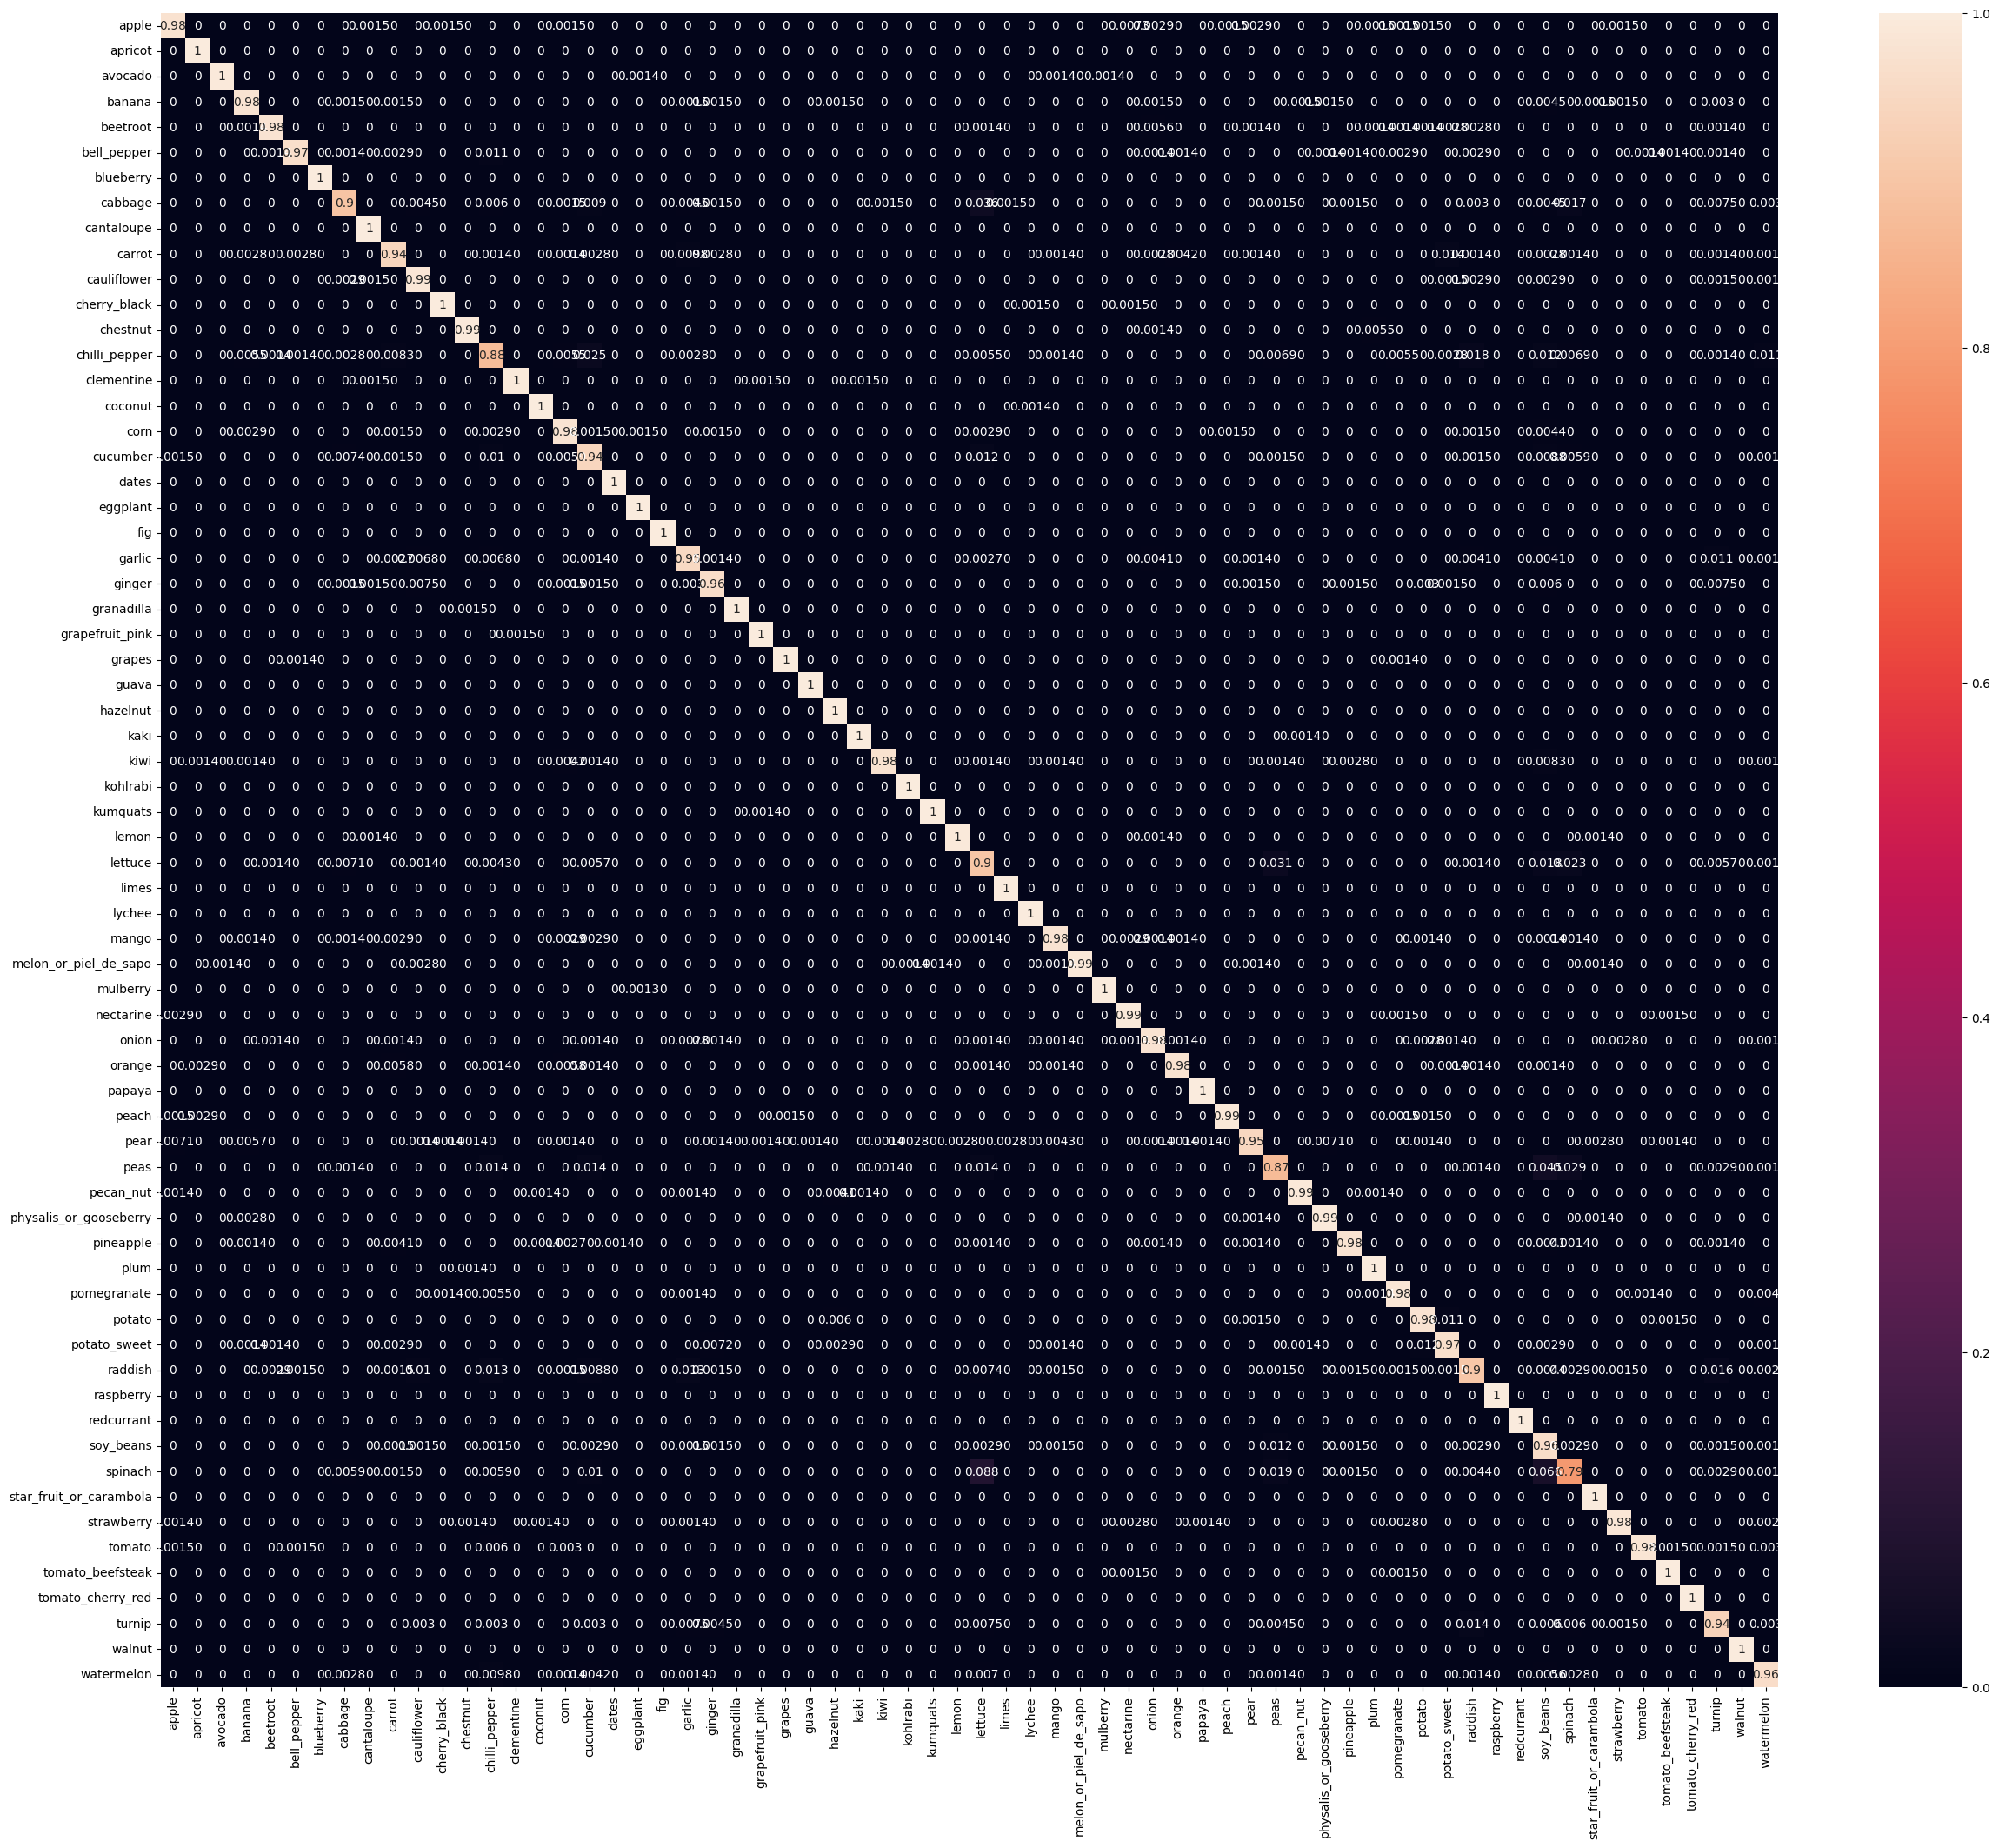

In [16]:
# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
classes = dataset.class_to_idx.keys()
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize=(30, 25))
sn.heatmap(df_cm, annot=True)
plt.savefig(f'CV_data/conf_matrix/{model_name}-output.pdf')

# Test examples

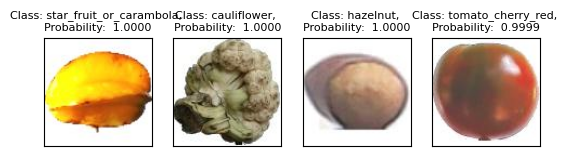

In [17]:
for batch_idx, (features, targets) in enumerate(test_loader):

    features = features
    targets = targets
    break

NUM_IMG = 4
fig, axs = plt.subplots(1, NUM_IMG)
imgs = []
classes = []

for idx in range(NUM_IMG):
    nhwc_img = np.transpose(features[idx], axes=(1, 2, 0))
    imgs.append(nhwc_img)

    model.eval()
    _ , probas = model(features.to(device)[idx, None])
    probas = probas.cpu().detach().numpy()

    classes.append(
        {"class": idx_to_class[np.argmax(probas[0])],
         "proba": np.max(probas[0])})

for i, ax in enumerate(axs.flat):
    if i < len(imgs):
        ax.imshow(imgs[i])
        ax.set_title(f'Class: {classes[i]["class"]}, \nProbability:  {classes[i]["proba"]:.4f}', fontsize=8)
    ax.set_xticks([])
    ax.set_yticks([])
    

# for idx in range(NUM_IMG):
    # print("Class: ", classes[idx]["class"], "\nProbability: ", classes[idx]["proba"], '\n')

# Own photos

In [56]:
import os
path = "CV_data/own_photos/"
path = "CV_data/own_photos_no_background/"
classes = os.listdir(path)
classes = [fldr for fldr in classes if not fldr.startswith('.')]

print(classes)

transform = transforms.Compose([
    transforms.Resize(RESOLUTION),
    transforms.CenterCrop(RESOLUTION),
    transforms.ToTensor()
])

custom_test_dataset = datasets.ImageFolder(root=path, transform=transform)

custom_test_loader = DataLoader(dataset=custom_test_dataset, 
                         batch_size=BATCH_SIZE, 
                         shuffle=True)


['mango', 'banana', 'apple', 'bell_pepper']


{'class': 'bell_pepper', 'proba': 0.99520004}
{'class': 'pomegranate', 'proba': 0.0026168777}
{'class': 'tomato', 'proba': 0.00084954593}
{'class': 'chilli_pepper', 'proba': 0.00033822746}
{'class': 'cherry_black', 'proba': 0.00027592608}


{'class': 'bell_pepper', 'proba': 0.99792093}
{'class': 'cherry_black', 'proba': 0.0009058758}
{'class': 'mango', 'proba': 0.00048165722}
{'class': 'pomegranate', 'proba': 0.0002900853}
{'class': 'tomato', 'proba': 0.00012862738}


{'class': 'bell_pepper', 'proba': 0.9486133}
{'class': 'tomato', 'proba': 0.02368466}
{'class': 'chilli_pepper', 'proba': 0.018387243}
{'class': 'cherry_black', 'proba': 0.0040406245}
{'class': 'pomegranate', 'proba': 0.0023859187}


{'class': 'ginger', 'proba': 0.9254516}
{'class': 'corn', 'proba': 0.04506687}
{'class': 'potato_sweet', 'proba': 0.020703133}
{'class': 'potato', 'proba': 0.0015915683}
{'class': 'kiwi', 'proba': 0.0014410546}




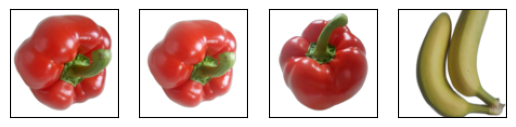

In [57]:
for batch_idx, (features, targets) in enumerate(custom_test_loader):

    features = features
    targets = targets
    break

NUM_IMG = 4
fig, axs = plt.subplots(1, NUM_IMG)
imgs = []
classes = []

for idx in range(NUM_IMG):
    nhwc_img = np.transpose(features[idx], axes=(1, 2, 0))
    imgs.append(nhwc_img)

    model.eval()
    _ , probas = model(features.to(device)[idx, None])
    probas = probas.cpu().detach().numpy()

    proba_indices = np.argsort(probas[0])[::-1][:5]  # Get indices of top 5 classes
    top_classes = [{"class": idx_to_class[idx], "proba": probas[0][idx]} for idx in proba_indices]
    classes.extend(top_classes)

for i, ax in enumerate(axs.flat):
    if i < len(imgs):
        ax.imshow(imgs[i])
    ax.set_xticks([])
    ax.set_yticks([])

for i, c in enumerate(classes):
    print(c)
    if ((i + 1) % 5) == 0:
        print('\n')

In [48]:
from lib.nutrifacts import retrieve_nutrition_facts
import json

from IPython.core.display import HTML
HTML("&micro;")

print(json.dumps(retrieve_nutrition_facts(classes[2]["class"]), indent=4))

{'Food_Group': 'Vegetables', 'Food Name': 'Chili pepper raw', 'Energy(kcal)': 30, 'Water(g)': '91,9', 'Protein(g)': '1,8', 'Fat(g)': '0,3', 'Fatty_acids_total(g)': '0,2', 'Fatty acids saturated total(g)': '0', 'Carbohydrate(g)': '4,2', 'Sugar(g)': '4,2', 'Starch(g)': '0', 'Fiber dietary total(g)': '1,8', 'Na(mg)': 12.0, 'K(mg)': 440.0, 'Ca(mg)': 16.0, 'P(mg)': 39.0, 'Mg(mg)': 21.0, 'Fe(mg)': '1', 'Cu(mg)': '0,17', 'Se(µg)': nan, 'Zn(mg)': '0,3', 'Id(µg)': nan, 'Vitamin_D(µg)': '0', 'Vitamin_E(mg)': nan, 'Vitamin_K(µg)': '14', 'Vitamin_B1(mg)': '0,12', 'Vitamin_B2(mg)': '0,15', 'Vitamin_B6(mg)': '0,28', 'Vitamin_B12(µg)': '0', 'Vitamin_B3(mg)': '2,2', 'Vitamin_C(mg)': 144.0, 'Vitamin_A': 0.0}
{
    "Food Name": "Chili pepper raw",
    "Energy(kcal)": 30,
    "Water(g)": 91.9,
    "Protein(g)": 1.8,
    "Fat(g)": 0.3,
    "Fatty_acids_total(g)": 0.2,
    "Carbohydrate(g)": 4.2,
    "Sugar(g)": 4.2,
    "Fiber dietary total(g)": 1.8,
    "Na(mg)": 12.0,
    "K(mg)": 440.0,
    "Ca(mg)": 1